## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

## Undistort an image

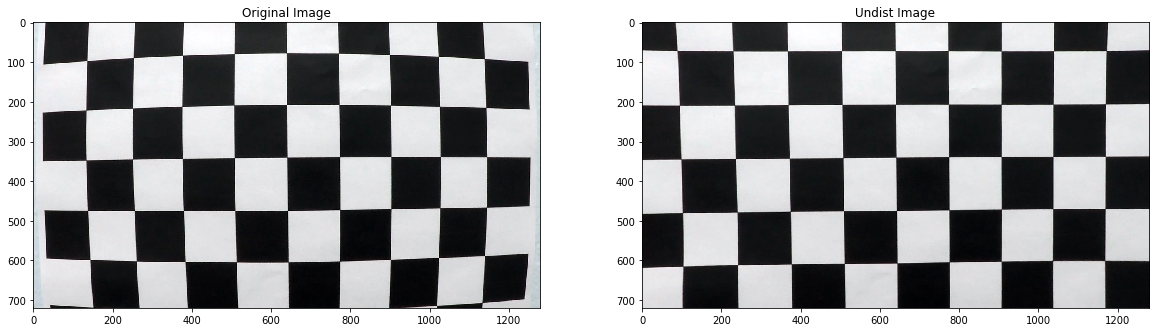

In [2]:
def undistort_img (img):
#     img_size = (img.shape[1], img.shape[0])
#     ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undist
img = cv2.imread(images[0])
img_undist =  undistort_img (img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(img)
ax2.set_title('Undist Image')
ax2.imshow(img_undist)

## Create a thresholded binary image

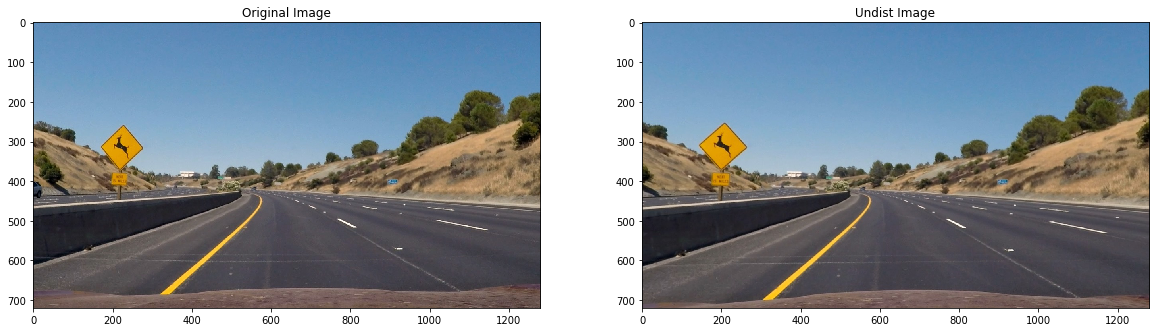

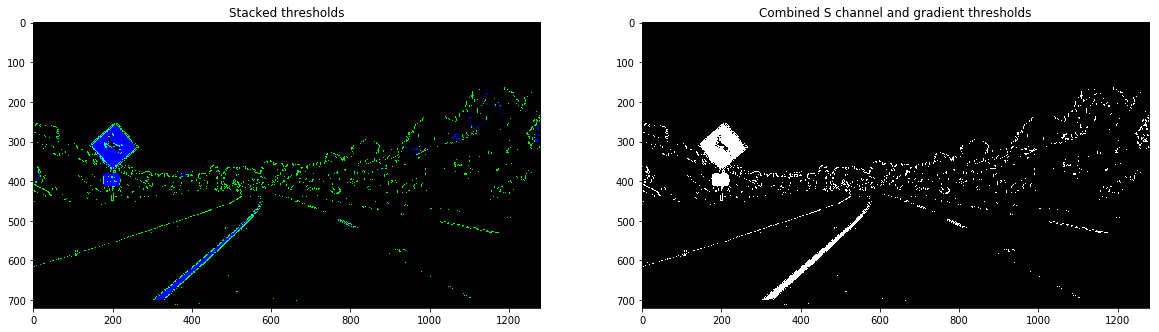

In [28]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    scaled_sobel = np.uint8(255*dir_gradient/np.max(dir_gradient))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(dir_gradient>=thresh[0]) & (dir_gradient<=thresh[1])] = 1
    return binary_output

def s_channel_threshold(image,thresh=(0, 255)):
    hls = cv2.cvtColor(img_undist, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary


def combined_binary_threshold(img_undist,ksize=5):
    #Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img_undist, orient='x', sobel_kernel=ksize, thresh=(40, 100))
    grady = abs_sobel_thresh(img_undist, orient='y', sobel_kernel=ksize, thresh=(0, 100))
    mag_binary = mag_thresh(img_undist, sobel_kernel=ksize, mag_thresh=(100, 100))
    dir_binary = dir_threshold(img_undist, sobel_kernel=ksize, thresh=(0.7, 1.3))
    s_binary = s_channel_threshold(img_undist,  thresh=(180, 255))

   # color_binary = np.dstack((np.zeros_like(dir_binary), ((gradx == 1)& (grady == 1))|((mag_binary == 1) & (dir_binary == 1)), s_binary))*255
    color_binary = np.dstack((np.zeros_like(dir_binary), gradx, s_binary))*255

    combined_binary = np.zeros_like(dir_binary)
   # combined_binary[((gradx == 1)& (grady == 1))|((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1) ] = 1
    combined_binary[(gradx== 1) | (s_binary == 1) ] = 1
    return color_binary, combined_binary

img = mpimg.imread("./test_images/test2.jpg")
img_undist = undistort_img (img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(img)
ax2.set_title('Undist Image')
ax2.imshow(img_undist)

color_binary, combined_binary = combined_binary_threshold(img_undist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

## Apply a perspective transform

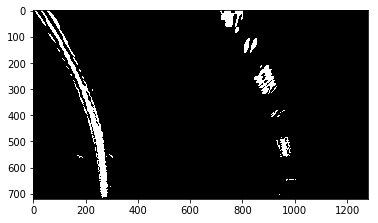

In [27]:
def perspective_transform(combined_binary):
    src = np.float32( [[(595,450),(685, 450), (1120, 720), (200,720)]])
    dst = np.float32( [[(200,0),(920, 0), (920, 720), (200,720)]])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (combined_binary.shape[1], combined_binary.shape[0])
    warped = cv2.warpPerspective(combined_binary,M,img_size,flags = cv2.INTER_LINEAR)
    return warped, Minv
warped, Minv= perspective_transform(combined_binary)
plt.imshow(warped,cmap = "gray")

## Detect lane pixels and fit to find the lane boundary

In [9]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
#     print(histogram)
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped)))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#     plotx = np.linspace(0, binary_warped.shape[1]-1, binary_warped.shape[1])
#     plt.plot(plotx,histogram)
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    blank_window_left = 0
    blank_window_right = 0
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin  
        win_xright_high = rightx_current + margin  
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#                       (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#                       (win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]  
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
 
        if len(good_left_inds) > minpix:
            if blank_window_left <= 3:         
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                left_lane_inds.append(good_left_inds)
                blank_window_left = 0
        else:
            blank_window_left += 1

        if len(good_right_inds) > minpix:  
            if blank_window_left <= 3:                
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                right_lane_inds.append(good_right_inds)
                blank_window_right = 0
        else:
            blank_window_right += 1

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    try:
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]   
    
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(warped,ym_per_pix = 30/720, xm_per_pix = 3.7/920):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
    left_fit_pixel = np.polyfit(lefty, leftx, 2)
    right_fit_pixel = np.polyfit(righty, rightx, 2)
    left_fit_real = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_real = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    return  left_fit_pixel, right_fit_pixel, left_fit_real, right_fit_real



## Determine the curvature of the lane and vehicle position with respect to center.

In [10]:
def polyfit_using_prev_fit(binary_warped, left_fit_pixel_prev, right_fit_pixel_prev ,ym_per_pix = 30/720, xm_per_pix = 3.7/920):
    margin = 80
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit_pixel_prev[0]*(nonzeroy**2) + left_fit_pixel_prev[1]*nonzeroy + 
                    left_fit_pixel_prev[2] - margin)) & 
                      (nonzerox < (left_fit_pixel_prev[0]*(nonzeroy**2) + left_fit_pixel_prev[1]*nonzeroy + 
                    left_fit_pixel_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_pixel_prev[0]*(nonzeroy**2) + right_fit_pixel_prev[1]*nonzeroy +
                    right_fit_pixel_prev[2] - margin)) & 
                       (nonzerox < (right_fit_pixel_prev[0]*(nonzeroy**2) + right_fit_pixel_prev[1]*nonzeroy + 
                    right_fit_pixel_prev[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_pixel_new = np.polyfit(lefty, leftx, 2)
    right_fit_pixel_new = np.polyfit(righty, rightx, 2)
    left_fit_real_new = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_real_new = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    return left_fit_pixel_new, right_fit_pixel_new, left_fit_real_new, right_fit_real_new

def measure_curvature_real(warped,left_fit_real, right_fit_real, ym_per_pix = 30/720, xm_per_pix = 3.7/920):
#     ploty, left_fit_cr, right_fit_cr = fit_polynomial_real(warped,ym_per_pix,xm_per_pix )
    y_eval = warped.shape[0]-1
    left_curverad = ((1 + (2*left_fit_real[0]*y_eval*ym_per_pix + left_fit_real[1])**2)**1.5) / np.absolute(2*left_fit_real[0])
    right_curverad = ((1 + (2*right_fit_real[0]*y_eval*ym_per_pix + right_fit_real[1])**2)**1.5) / np.absolute(2*right_fit_real[0])
    curverad = (left_curverad + right_curverad)/2
    Radius_of_curvature = "Radius of curvature = {:.2f}m".format(curverad)
    return Radius_of_curvature

def distance_to_lane_center(warped,left_fit_real, right_fit_real, ym_per_pix = 30/720, xm_per_pix = 3.7/920):
#     ploty, left_fit_cr, right_fit_cr = fit_polynomial_real(warped,ym_per_pix, xm_per_pix)
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    y_eval = np.max(ploty)*ym_per_pix
    left_x_eval = left_fit_real[0]*y_eval**2 + left_fit_real[1]*y_eval + left_fit_real[2]
    right_x_eval = right_fit_real[0]*y_eval**2 + right_fit_real[1]*y_eval + right_fit_real[2]
    lane_center = (left_x_eval + right_x_eval)/2
    car_postion = warped.shape[1]/2*xm_per_pix
    distance =  np.absolute(car_postion - lane_center)
    
    
    if car_postion >= lane_center:
        left_or_right = "right"
    else:
        left_or_right = "left"
    Vehicle_diatance_to_center = "Vehicle is {:.2f}m {} of center".format(distance,left_or_right)
    return Vehicle_diatance_to_center
#print("Radius of curvature = ","left:%.2fm"%left_curverad, "right:%.2fm"%right_curverad)
#print("Vehicle is","%.2fm"%distance,left_or_right,"of center" )

#Radius_of_curvature = "Radius of curvature = {:.2f}m".format(curverad)
#Vehicle_diatance_to_center = "Vehicle is {:.2f}m {} of center".format(distance,left_or_right)

## Warp the detected lane boundaries back onto the original image

In [11]:
def original_image_boundaries(img_undist,warped,left_fit_pixel, right_fit_pixel, Minv,Vehicle_diatance_to_center,Radius_of_curvature):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit_pixel[0]*ploty**2 + left_fit_pixel[1]*ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0]*ploty**2 + right_fit_pixel[1]*ploty + right_fit_pixel[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_undist.shape[1], img_undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
    cv2.putText(result,Radius_of_curvature,(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(result,Vehicle_diatance_to_center,(50,100),cv2.FONT_HERSHEY_SIMPLEX ,1,(255,255,255),2)
    #plt.imshow(result)
    return result

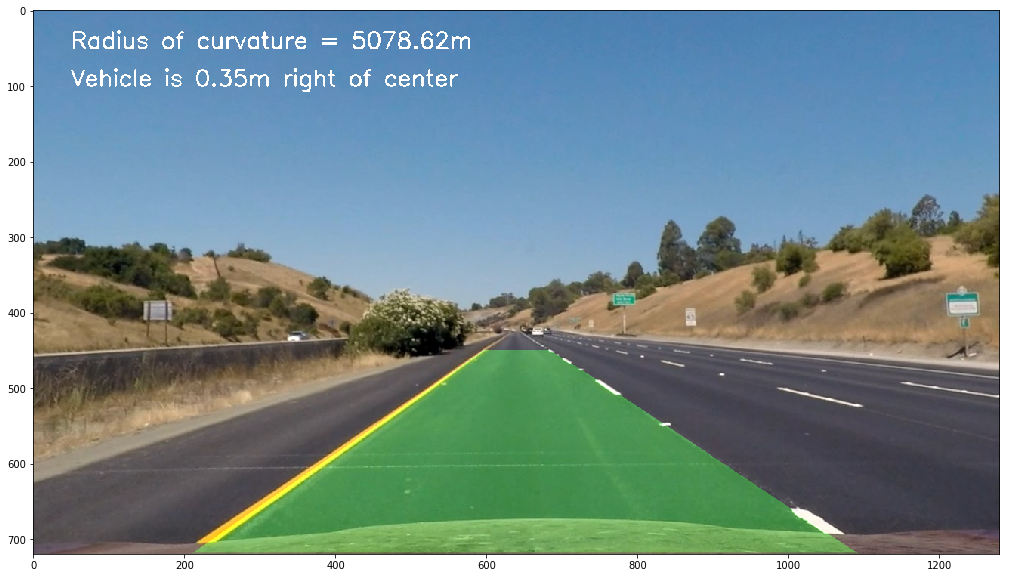

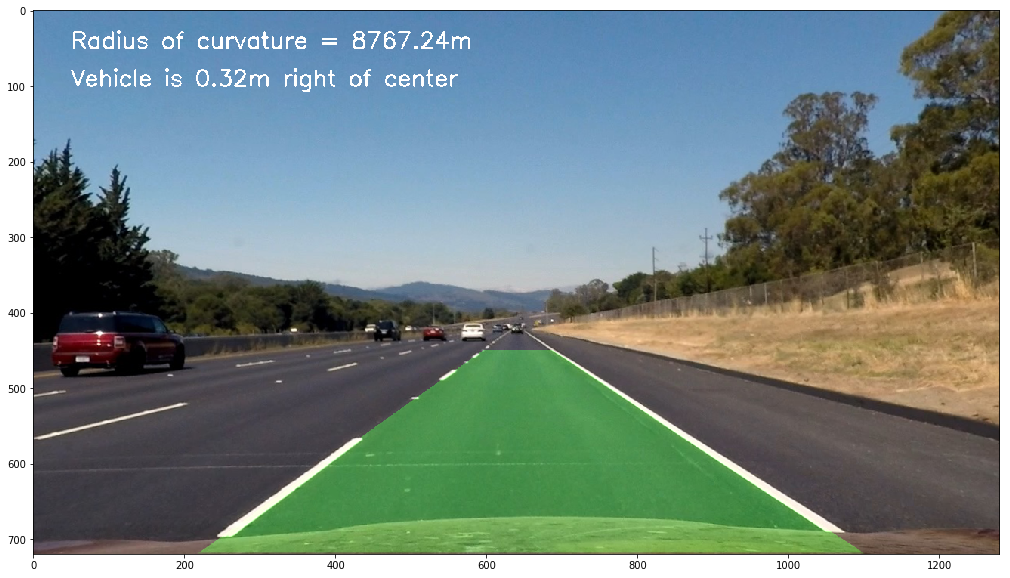

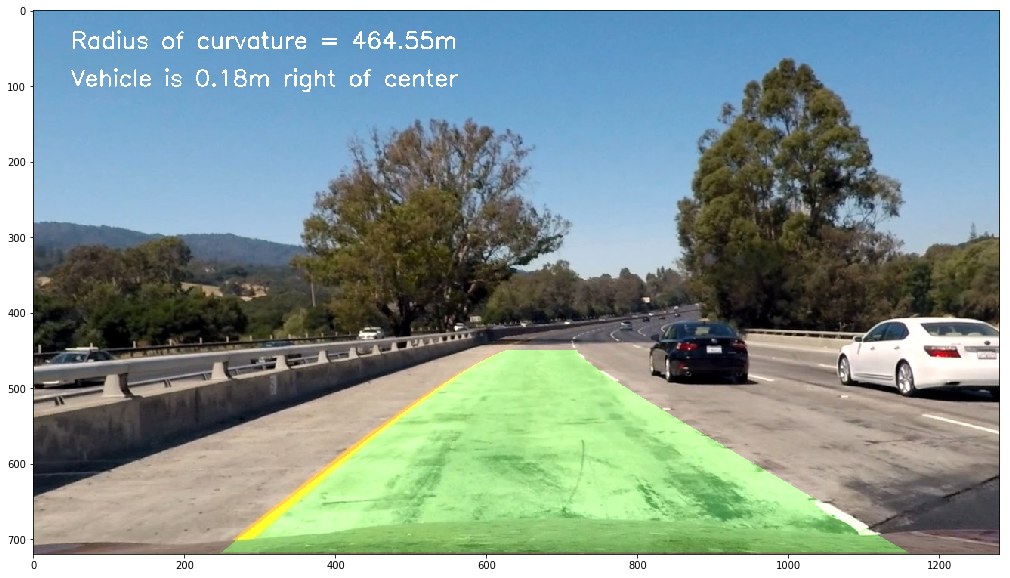

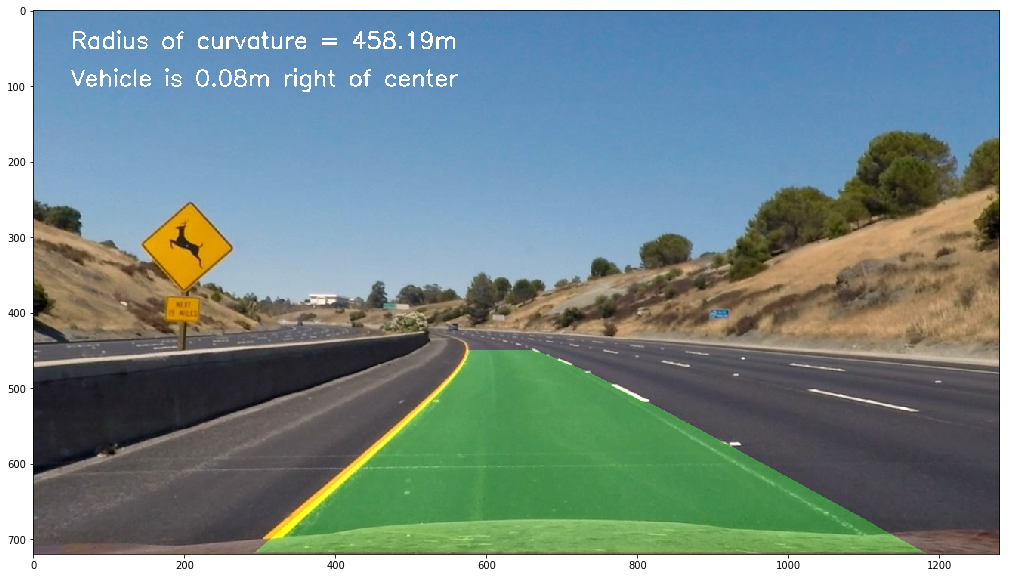

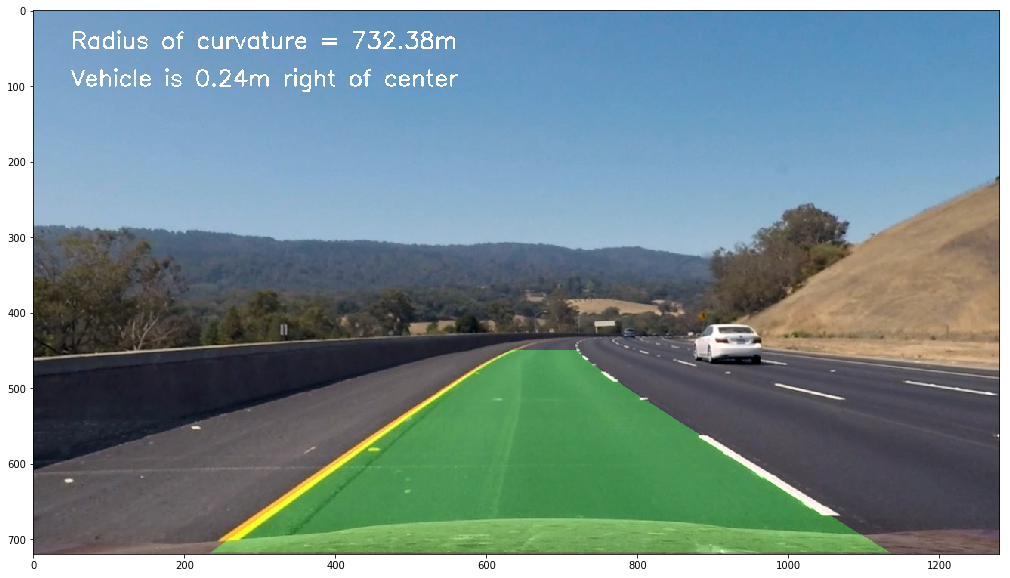

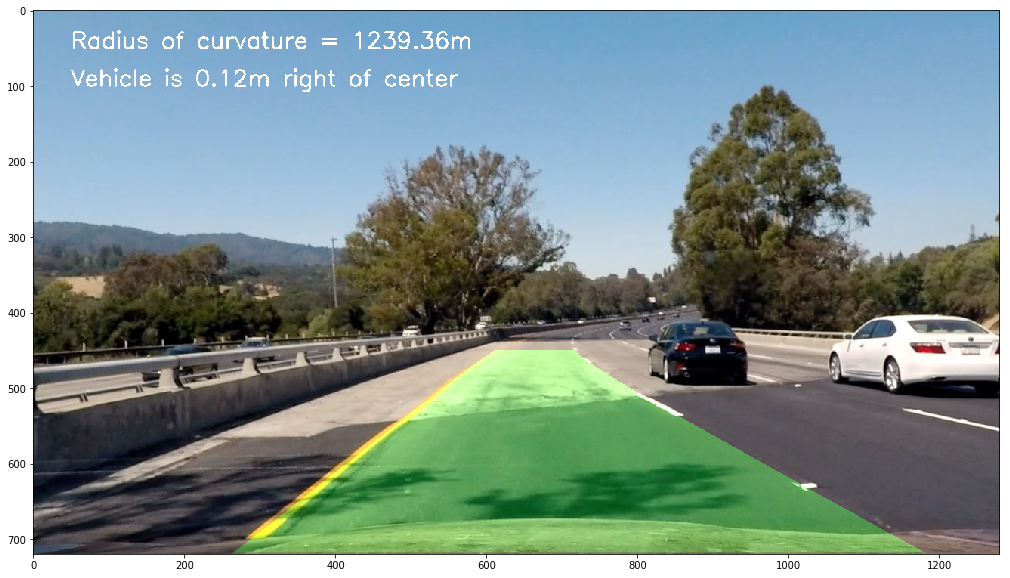

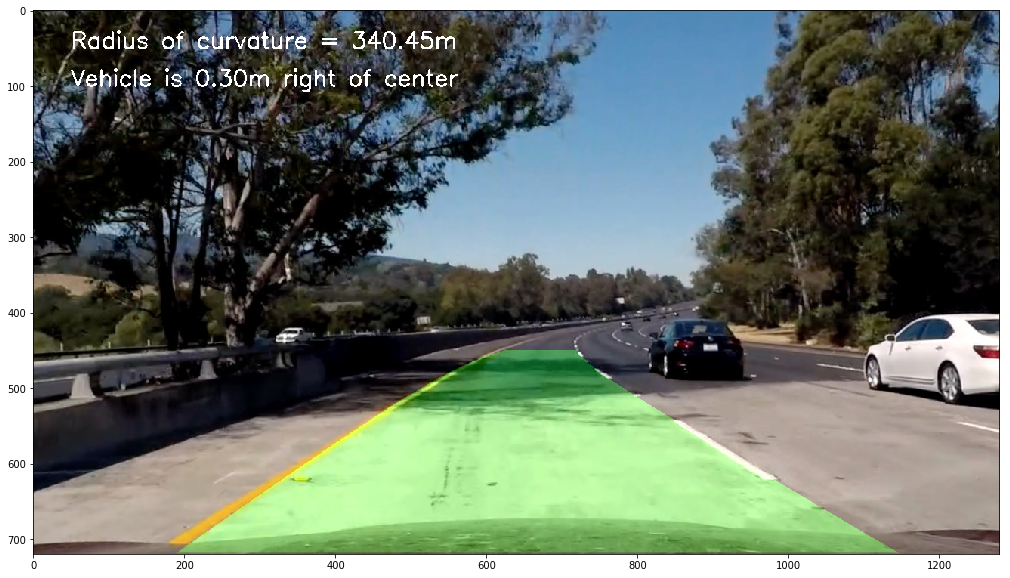

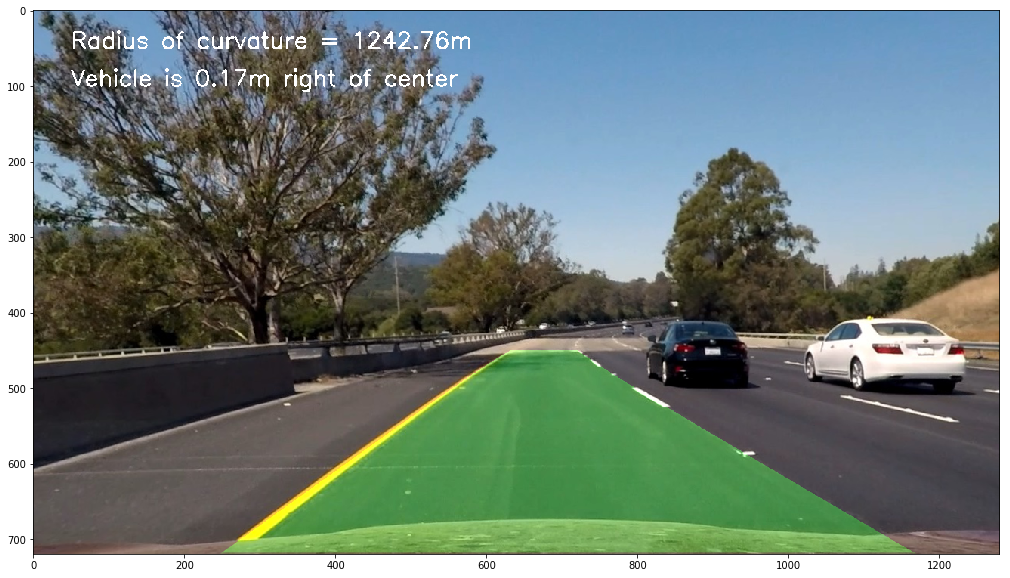

In [9]:
all_direct = os.listdir("../test_images/")
for i in range(len(all_direct)):
    direct = "../test_images/{}".format(all_direct[i])
    img = mpimg.imread(direct)
    img_undist = undistort_img(img)
    color_binary, combined_binary = combined_binary_threshold(img_undist)
    warped, Minv = perspective_transform(combined_binary)
    left_fit_pixel, right_fit_pixel, left_fit_real, right_fit_real = fit_polynomial(warped) 
    Vehicle_diatance_to_center = distance_to_lane_center(warped,left_fit_real, right_fit_real)
    Radius_of_curvature = measure_curvature_real(warped,left_fit_real, right_fit_real)
    result = original_image_boundaries(img_undist,warped,left_fit_pixel,right_fit_pixel,Minv,Vehicle_diatance_to_center,Radius_of_curvature)
    fig = plt.figure(figsize=(20,10))
    plt.imshow(result)
    plt.show()
    #save to folder"../output_images/"
    result = cv2.cvtColor(result,cv2.COLOR_RGB2BGR)
    new_direct = "../output_images/{}".format(all_direct[i])
    cv2.imwrite(new_direct, result)
    

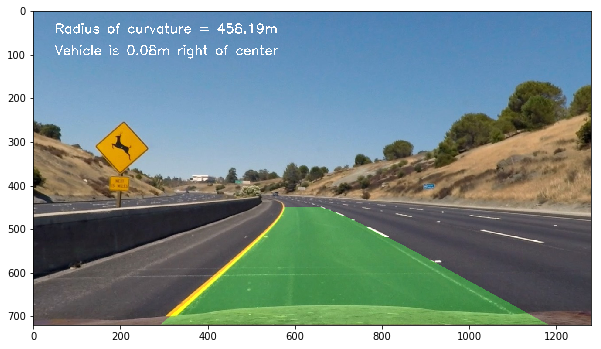

In [36]:
#direct = "../test_images/{}".format(all_direct[i])
img = mpimg.imread("./test_images/test2.jpg")
#print(direct)
img_undist = undistort_img(img)
# plt.imshow(img_undist)
# plt.show()
color_binary, combined_binary = combined_binary_threshold(img_undist)
warped, Minv = perspective_transform(combined_binary)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.set_title('Binary Image')
# ax1.imshow(combined_binary, cmap = "gray")
# ax2.set_title('Warped Image')
# ax2.imshow(warped,cmap = "gray")
left_fit_pixel, right_fit_pixel, left_fit_real, right_fit_real = fit_polynomial(warped) 
Vehicle_diatance_to_center = distance_to_lane_center(warped,left_fit_real, right_fit_real)
Radius_of_curvature = measure_curvature_real(warped,left_fit_real, right_fit_real)
result = original_image_boundaries(img_undist,warped,left_fit_pixel,right_fit_pixel,Minv,Vehicle_diatance_to_center,Radius_of_curvature)
fig = plt.figure(figsize=(10,10))
plt.imshow(result)
plt.show()

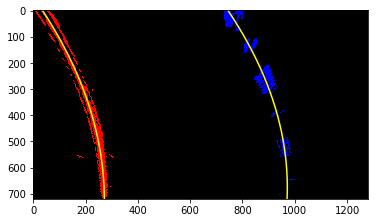

In [26]:
def fit_polynomial_visual(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
#     Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return ploty, left_fitx, right_fitx, out_img

ploty, left_fitx, right_fitx, out_img = fit_polynomial_visual(warped)
plt.imshow(out_img)


## Define a Line Class for Storing Data

In [10]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False 
        self.fit_real = []
        self.fit_pixel = []
    #def addfit(self, )
    def add_fit(self, fit_real,fit_pixel):
        if fit_real is not None:
            self.detected = True
            self.fit_real = fit_real
            self.fit_pixel = fit_pixel
        else:
            self.detected = False

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
   
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below 
    img_undist = undistort_img(image)
    color_binary, combined_binary = combined_binary_threshold(img_undist)
    warped, Minv = perspective_transform(combined_binary)
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        left_fit_pixel, right_fit_pixel, left_fit_real, right_fit_real = fit_polynomial(warped) 
        l_line.add_fit(left_fit_real,left_fit_pixel)
        r_line.add_fit(right_fit_real, right_fit_pixel)
    else:
        left_fit_pixel_new, right_fit_pixel_new, left_fit_real_new, right_fit_real_new = polyfit_using_prev_fit(warped, l_line.fit_pixel, r_line.fit_pixel)
        l_line.add_fit(left_fit_real_new, left_fit_pixel_new)
        r_line.add_fit(right_fit_real_new, right_fit_pixel_new) 
                                                    
    Vehicle_diatance_to_center = distance_to_lane_center(warped,l_line.fit_real, r_line.fit_real)
    Radius_of_curvature = measure_curvature_real(warped,l_line.fit_real, r_line.fit_real)
    result = original_image_boundaries(img_undist,warped,l_line.fit_pixel,r_line.fit_pixel,Minv,Vehicle_diatance_to_center,Radius_of_curvature)
    return result

In [12]:
l_line = Line()
r_line = Line()
white_output = '../test_videos_output/project_video_output.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../test_videos_output/project_video_output3.mp4
[MoviePy] Writing video ../test_videos_output/project_video_output3.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:10<00:00,  2.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_videos_output/project_video_output3.mp4 

Wall time: 10min 12s
